<center><h1>Analysis of geolocation data in Colombia</h1></center>

# 1. Business Problem Section

We are going to explore the cities of Colombia and be able to determine the similarities between each city.

In the country of Colombia, universities are in the main cities, so many students from distant cities find themselves with the need to travel and change homes during the study period, in general these university cities are more expensive and complicated than manage in economic terms, social terms, etc.

Being able to determine the similarity of a city to find a place to live near the university, but in a place that resembles the city of origin, and to seek benefits in terms of economy, habits, places to frequent; based on venues comparison using the Foursquare liberia.

In the end, when you decide to go to study at a university, you do not necessarily have to move to the main city that is more expensive and difficult to maintain, but you can go to a closer, more sustainable, beneficial city that generates easy access to the university with some simpler means of transport.

# 2. Data Section

GeoNames is a large open access database, the result of the impressive work of Marc Wick and colleagues, that gathers geographic information from places around the world.

### Coordinates Collection

Only the necessary data such as the name of the city, Latitude, Longitude and the name of the department have been selected.

The department and the city are in two different databases, so both will be loaded and merged into a single dataframe.

<b>Source: </b> <a href="https://carta-natal.es/descargas/geo.php">https://carta-natal.es/descargas/geo.php</a>

<b>Data Source: </b> <a href="https://carta-natal.es/descargas/coordenadas.php?file=46">https://carta-natal.es/descargas/coordenadas.php?file=46</a>

<table>
    <thead>
        <tr><th>Column</th><th>Descrption</th></tr>
    </thead>
    <tbody>
        <tr><td><b>name:</b></td><td>name of the town</td></tr>
        <tr><td><b>latitude:</b></td><td>latitude, decimal (wgs84)</td></tr>
        <tr><td><b>length:</b></td><td>length, decimal (wgs84)</td></tr>
        <tr><td><b>type:</b></td><td>PPL for populated places, PPLC for capitals</td></tr>
        <tr><td><b>iso code:</b></td><td>ISO-3166 country code, 2 characters.</td></tr>
        <tr><td><b>admin1:</b></td><td>top-level senior management.</td></tr>
        <tr><td><b>admin2:</b></td><td>upper second level administration.</td></tr>
        <tr><td><b>timezone:</b></td><td>time zone identifier.</td></tr>
    </tbody>
<table>

We will also use the services of the Foursquare library, in order to obtain the geolocation of the different venues for a certain city, based on the previous dataset.

# 3. Methodology Section

In [1]:
import pandas as pd
import numpy as np
import requests

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Before starting with the case study, let's first load the datasets that contain the information for departments and cities in Colombia, which have previously been uploaded to a GitHub repository.

The first dataset contains the municipality, latitude, longitude, the type of place (city or capital) and the time zone ientifier.

In [2]:
cities = pd.read_csv('data/CO.txt', sep = ';', header=None)
cities.columns = ['town', 'latitude', 'longitude', 'type', 'isocode', 'admin1', 'admin2', 'timezone']
cities.head()

,town,latitude,longitude,type,isocode,admin1,admin2,timezone
0,A Bravo,8.61134,-76.44397,PPL,CO,2,NaN,America/Bogota
1,Abarca,10.76667,-74.16667,PPL,CO,38,NaN,America/Bogota
2,Abejorral,5.78928,-75.42725,PPL,CO,2,NaN,America/Bogota
3,Abisinia,-1.38333,-72.20000,PPL,CO,1,NaN,America/Bogota
4,Abrahan Asprilla,5.00000,-77.16667,PPL,CO,11,NaN,America/Bogota


In the second dataset, it contains the code for the department and the name of the department.

In [3]:
Departments = pd.read_csv('data/Admin 1.txt', sep = ';', header=None)
Departments.columns = ['iso', 'code', 'departmentname']
Departments.head()

,iso,code,departmentname
0,CO,0,Colombia (general)
1,CO,1,Amazonas
2,CO,2,Antioquia
3,CO,3,Arauca
4,CO,4,Atlántico


We are going to unify the two datasets to contain all the necessary information in a single dataset, which will be the one with which we will carry out the case study and analysis.

In [4]:
cities_df = cities.join(Departments.set_index('code'), on='admin1')
cities_df.head()

,town,latitude,longitude,type,isocode,admin1,admin2,timezone,iso,departmentname
0,A Bravo,8.61134,-76.44397,PPL,CO,2,NaN,America/Bogota,CO,Antioquia
1,Abarca,10.76667,-74.16667,PPL,CO,38,NaN,America/Bogota,CO,Magdalena
2,Abejorral,5.78928,-75.42725,PPL,CO,2,NaN,America/Bogota,CO,Antioquia
3,Abisinia,-1.38333,-72.20000,PPL,CO,1,NaN,America/Bogota,CO,Amazonas
4,Abrahan Asprilla,5.00000,-77.16667,PPL,CO,11,NaN,America/Bogota,CO,Chocó


### Data analysis

To analyze the data in the dataset, we will first review and identify all columns that are not relevant, starting with identifying null values and unique values.

In [5]:
print(cities_df.groupby('type')["town"].nunique(), "\n")
print(cities_df.groupby('isocode')["town"].nunique(), "\n")
print(cities_df.groupby('admin2')["town"].nunique(), "\n")
print(cities_df.groupby('timezone')["town"].nunique(), "\n")
print(cities_df.groupby('iso')["town"].nunique(), "\n")

type
PPL      12749
PPLA        30
PPLA2        4
PPLC         1
PPLL       600
PPLQ         1
PPLS         3
PPLX       288
STLMT        1
Name: town, dtype: int64 

isocode
CO    13139
Name: town, dtype: int64 

Series([], Name: town, dtype: int64) 

timezone
America/Bogota       13130
America/Caracas         15
America/Guayaquil        3
America/Lima             4
Name: town, dtype: int64 

iso
CO    13139
Name: town, dtype: int64 



Based on the above, the isocode and iso variables are removed from the dataset because they are constants of a single value; We also remove admin1, since 100% are missing values; finally, admin1, since it has the same information, we obtain it from the departmentname attribute and they do not represent added value to the dataset and the analysis to be performed.

The final dataset looks like this:

In [6]:
cities_df = cities_df.drop(['isocode', 'admin2', 'iso', 'admin1','type','timezone'], axis=1)
cities_df.head()

,town,latitude,longitude,departmentname
0,A Bravo,8.61134,-76.44397,Antioquia
1,Abarca,10.76667,-74.16667,Magdalena
2,Abejorral,5.78928,-75.42725,Antioquia
3,Abisinia,-1.38333,-72.20000,Amazonas
4,Abrahan Asprilla,5.00000,-77.16667,Chocó


We verify the number of departments and towns that the datase contains.

In [7]:
print('The df has {} departmentname and {} towns.'.format(len(cities_df['departmentname'].unique()),cities_df.shape[0]))

The df has 34 departmentname and 29065 towns.


The dataset contains the coordinates for all the towns, but it is necessary to add two new attributes (longitude and latitude) for the departments, therefore, the Nominatim library is used to generate this information.

In [8]:
geolocator = Nominatim(user_agent="ny_explorer")
dep_list = []

for name_dep in zip(cities_df['departmentname'].unique()):
    address = '{}, Colombia'.format(name_dep[0])
    location = geolocator.geocode(address)
    
    if(location is None):
        dep_list.append([name_dep, np.nan, np.nan])
    else:
        latitude = location.latitude
        longitude = location.longitude
        dep_list.append([name_dep[0], location.latitude, location.longitude])
        
deps_df = pd.DataFrame(dep_list)
deps_df.columns = ['dep_name', 'dep_latitude', 'dep_longitude']
deps_df.head()

,dep_name,dep_latitude,dep_longitude
0,Antioquia,7.153843,-75.444040
1,Magdalena,10.000008,-74.500009
2,Amazonas,-1.019714,-71.938333
3,Chocó,6.000008,-77.000009
4,La Guajira,11.278011,-72.613577


The final dataset with which the rest of the analysis will be worked is the following:

In [9]:
cities_co = deps_df.join(cities_df.set_index('departmentname'), on='dep_name')
print("shape: ", cities_co.shape)
cities_co.head()

shape:  (29033, 6)


,dep_name,dep_latitude,dep_longitude,town,latitude,longitude
0,Antioquia,7.153843,-75.44404,A Bravo,8.61134,-76.44397
0,Antioquia,7.153843,-75.44404,Abejorral,5.78928,-75.42725
0,Antioquia,7.153843,-75.44404,Abriaqui,6.63148,-76.06444
0,Antioquia,7.153843,-75.44404,Abriojo,6.91667,-75.83139
0,Antioquia,7.153843,-75.44404,Agua Linda,6.33778,-75.60765


In [10]:
address = 'Colombia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Colombia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Colombia are 2.8894434, -73.783892.


We are going to make an initial location of all the departments of Colombia, as shown in the following map:

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=5)
deps_nan = deps_df.dropna()

# add markers to map
for de, lat, lng, in zip(deps_nan['dep_name'], deps_nan['dep_latitude'], deps_nan['dep_longitude']):
    
    label = '{}'.format(de)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)

map_newyork

Initially and for the purpose of understanding the data and seeing its complexity, the analysis will be done on only one department of Colombia. Colombia has 29033 towns, with which we will start the analysis and apply the algorithm, an automatic learning algorithm for the purpose of the case study, which will be Kmeans.

In [12]:
Cundinamarca_data = cities_co#cities_co[cities_co['dep_name'] == 'Antioquia'].reset_index(drop=True)
print(Cundinamarca_data.shape)
Cundinamarca_data = Cundinamarca_data.dropna()
Cundinamarca_data.head()

(29033, 6)


,dep_name,dep_latitude,dep_longitude,town,latitude,longitude
0,Antioquia,7.153843,-75.44404,A Bravo,8.61134,-76.44397
0,Antioquia,7.153843,-75.44404,Abejorral,5.78928,-75.42725
0,Antioquia,7.153843,-75.44404,Abriaqui,6.63148,-76.06444
0,Antioquia,7.153843,-75.44404,Abriojo,6.91667,-75.83139
0,Antioquia,7.153843,-75.44404,Agua Linda,6.33778,-75.60765


In [ ]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[Cundinamarca_data.iloc[0:1,1], Cundinamarca_data.iloc[0:1,2]], zoom_start=8)
deps_nan = deps_df.dropna()

# add markers to map
for de, lat, lng, in zip(Cundinamarca_data['town'], Cundinamarca_data['latitude'], Cundinamarca_data['longitude']):
    
    label = '{}'.format(de)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)

map_newyork

In [19]:
# @hidden_cell

### Analyze Each Town

To analyze each town, we will use the Foursquare api, where we will have to define attributes such as the version and the limit of venues that we will obtain for each town.

In [20]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

We create a cycle to go through each town, where based on the longitude and latitude of each one, we call the Foursquare api to the explorer method, using the following URL:

https://api.foursquare.com/v2/venues/explore

Once we obtain the venues associated with the town, we add it to a list which we convert into a dataset, which will contain and add the venues found for all the towns of the department of Cundinamarca.

In [21]:
venues_list=[]
radius = 500
errors = 0

for name, lat, lng in zip(Cundinamarca_data['town'], Cundinamarca_data['latitude'], Cundinamarca_data['longitude']):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
    
    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print('Neighbourhood: {}, Venues: {}'.format(name, len(results)))
        
        venues_list.append([(name,lat,lng,
                             v['venue']['name'],
                             v['venue']['location']['lat'],
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])
    except:
        errors = errors + 1
    
Cundinamarca_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
Cundinamarca_venues.columns = ['town', 'town_latitude', 'town_longitude', 
                          'venue', 'venue_latitude', 'venue_longitude', 'venue_category']

print(Cundinamarca_venues.shape)
Cundinamarca_venues.head()

(460, 7)


,town,town_latitude,town_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Abejorral,5.78928,-75.42725,Bon Appétit,5.788995,-75.427322,Restaurant
1,Abejorral,5.78928,-75.42725,Parque De La Independencia,5.791887,-75.428740,Plaza
2,Abejorral,5.78928,-75.42725,Los Toldos,5.792198,-75.426080,Colombian Restaurant
3,Agua Linda,6.33778,-75.60765,Lácteos La Holandesa No. 2,6.337496,-75.605702,Cheese Shop
4,Agua Linda,6.33778,-75.60765,Tienda Del Viejo Camino,6.340625,-75.607775,Colombian Restaurant


460 places obtained by the Quadrangular library, which implies that in relation to the towns of Colombia, not everyone has a record of at least one venue in the api of the foursquare library; It can imply a risk for the analysis because it is an inefficiency of a certain form of the api to host geolocation data for Colombia.

In accordance with the above, we will continue the analysis to determine which towns information was obtained and see how viable it is to be able to classify them to determine and reach the objective of the analysis.

The df has 111 town and 460 venues.


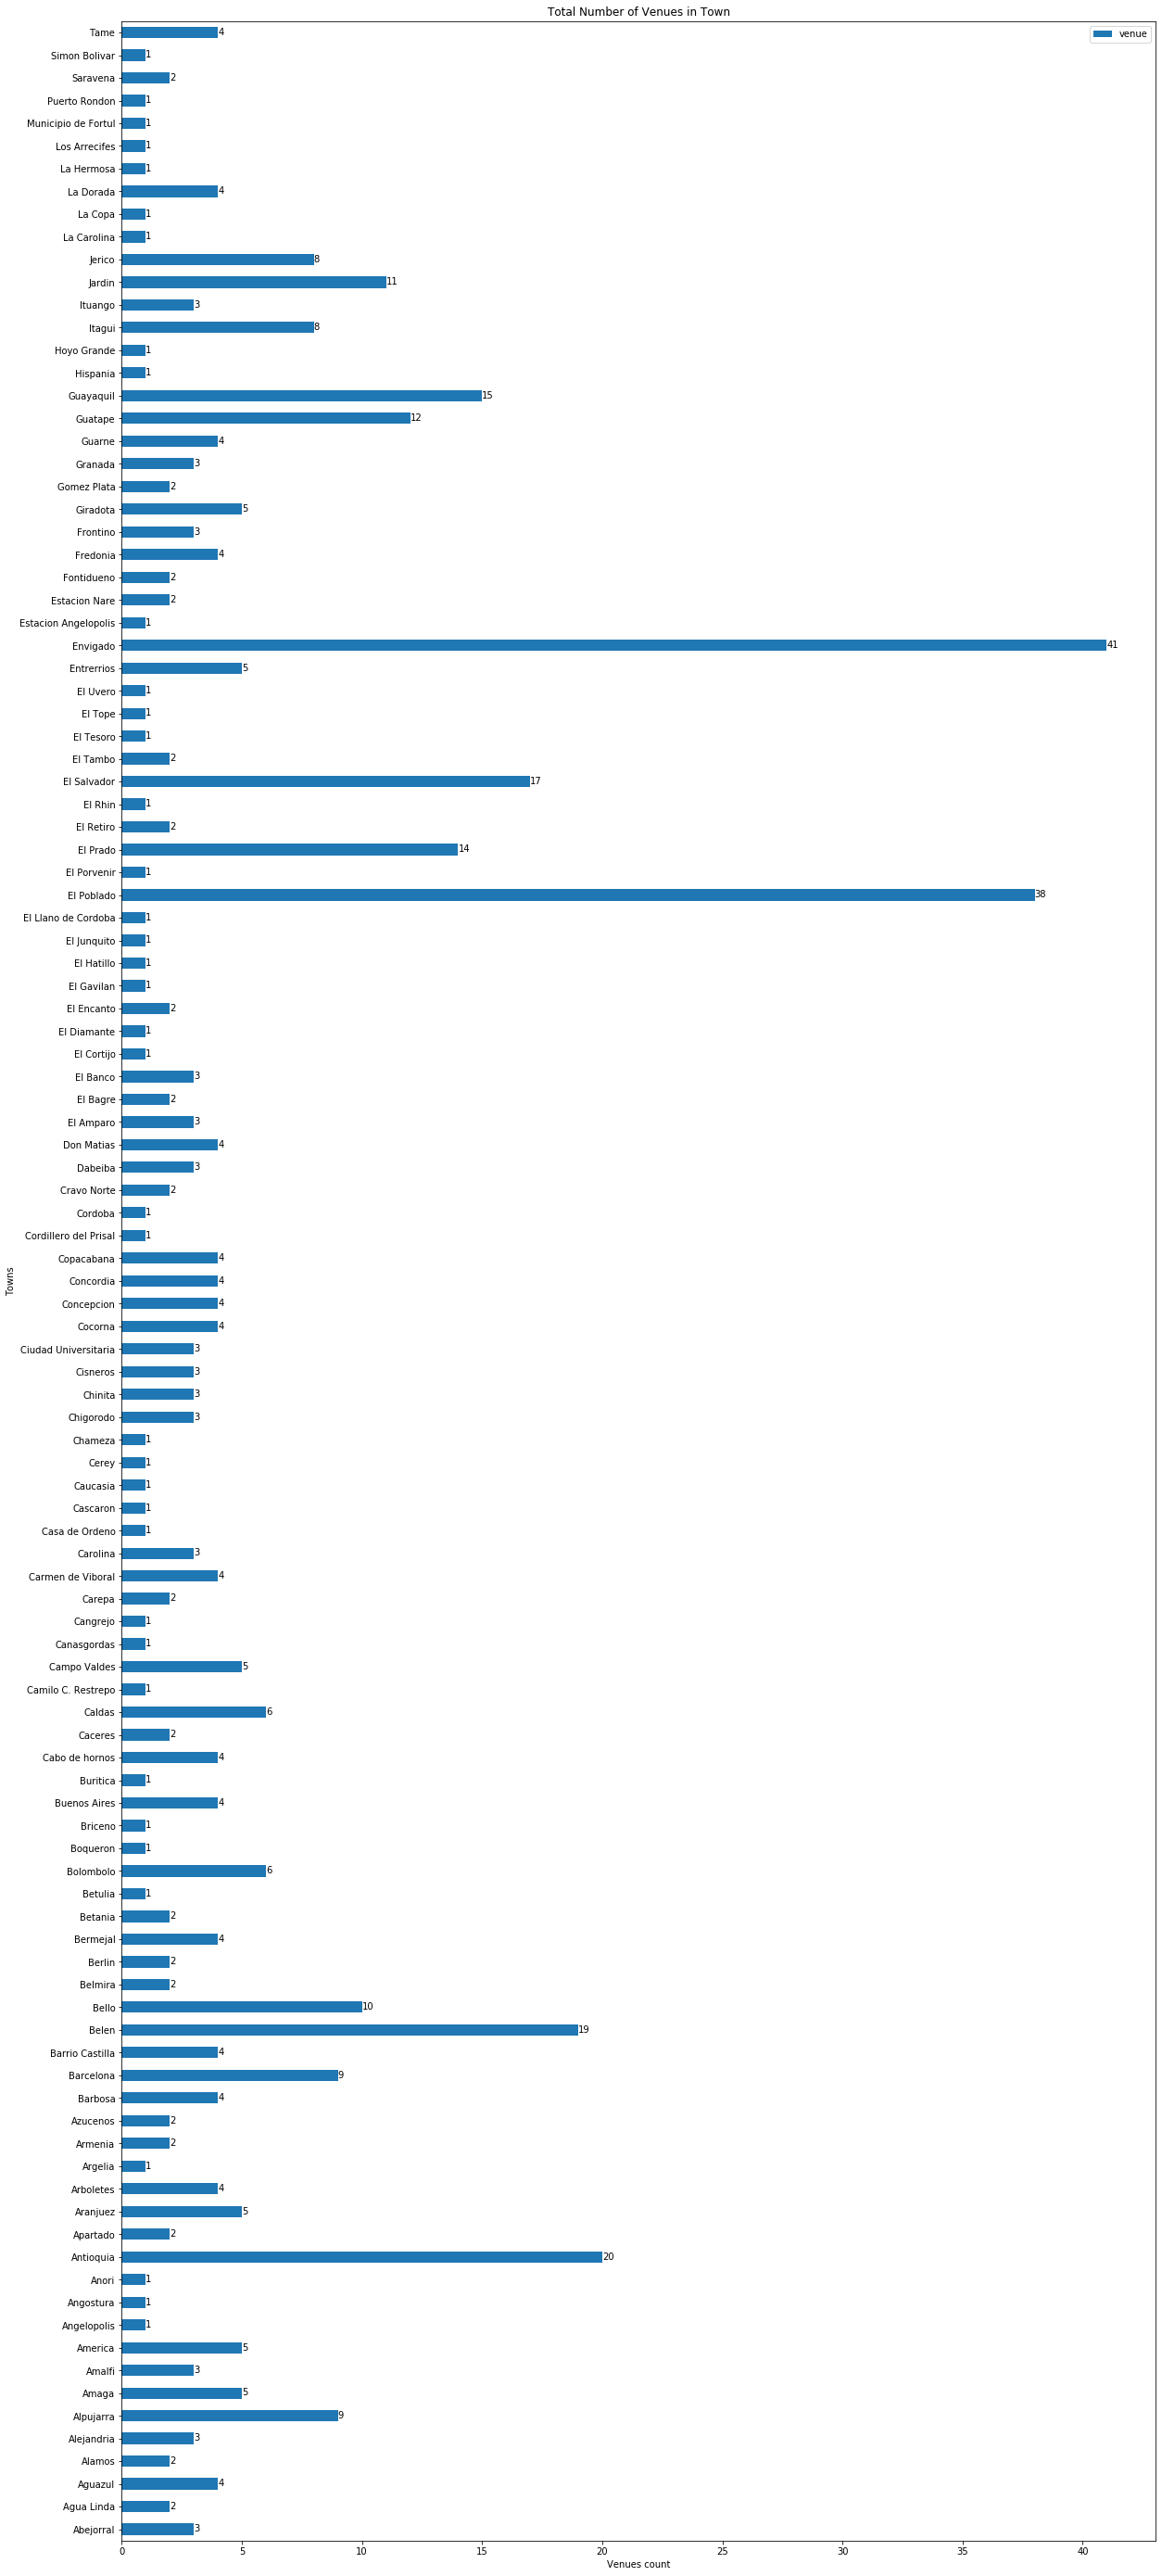

In [23]:
count_venues = Cundinamarca_venues.groupby(by=["town"]).count()
count_venues = count_venues[["venue"]]

print('The df has {} town and {} venues.'.format(len(Cundinamarca_venues['town'].unique()),Cundinamarca_venues.shape[0]))

count_venues.plot(kind='barh', figsize=(20, 50))
plt.xlabel('Venues count') # add to x-label to the plot
plt.ylabel('Towns') # add y-label to the plot
plt.title('Total Number of Venues in Town') # add title to the plot

for index, value in enumerate(count_venues.values.tolist()):
    label = format(int(value[0]), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value[0], index - 0.10), color='black')
    
plt.show()

We only obtained headquarters for 111 towns, less than 50% of all the towns in Colombia, even so, we consider it enough to complete the analysis for this department, since it can be valuable that we can find from them.

### Cluster Towns

We are going to run the k-means algorithm to classify the Colombia tows based on the categories of the venues obtained, therefore, we are going to convert each category into binary variables since we need them to be numeric as a requirement for k-means.

In [24]:
cindi_onehot = pd.get_dummies(Cundinamarca_venues[['venue_category']], prefix="", prefix_sep="")
cindi_onehot['town'] = Cundinamarca_venues['town']

fixed_columns = [cindi_onehot.columns[-1]] + list(cindi_onehot.columns[:-1])
cindi_onehot = cindi_onehot[fixed_columns]

print(cindi_onehot.shape)
cindi_onehot.head()

(460, 136)


,town,Airport,Airport Service,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,...,Taco Place,Theater,Theme Park,Theme Restaurant,Toll Booth,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Warehouse Store,Water Park
0,Abejorral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abejorral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abejorral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agua Linda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agua Linda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by town and by taking the mean of the frequency of occurrence of each category.

In [25]:
cindi_grouped = cindi_onehot.groupby('town').mean().reset_index()
print(cindi_grouped.shape)
cindi_grouped

(111, 136)


,town,Airport,Airport Service,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,...,Taco Place,Theater,Theme Park,Theme Restaurant,Toll Booth,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Warehouse Store,Water Park
0,Abejorral,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agua Linda,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aguazul,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alamos,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alejandria,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Municipio de Fortul,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,Puerto Rondon,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,Saravena,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,Simon Bolivar,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
cindi_clustering = cindi_grouped.drop('town', 1)
cindi_clustering.head()

,Airport,Airport Service,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Taco Place,Theater,Theme Park,Theme Restaurant,Toll Booth,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Warehouse Store,Water Park
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


K-Means algorithm is one of the most common cluster method of unsupervised learning.

Before running the K-means algorithm, we first use a loop to determine the best value of K, and then we run the algorithm with the best suggested one.

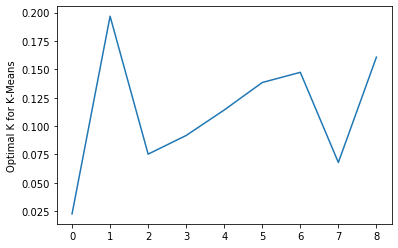

In [30]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(cindi_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(cindi_clustering, labels, metric = 'euclidean'))

plt.plot(sil)
plt.ylabel('Optimal K for K-Means')
plt.show()

We will execute K-Means to group the towns in 3 according to what the graph suggests.

In [31]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cindi_clustering)
labels = k_means.labels_

print(labels)

[2 2 0 2 1 2 2 2 2 1 0 0 2 2 2 2 1 1 1 2 2 2 2 2 1 2 1 1 0 2 2 2 2 0 2 0 2
 2 2 2 0 0 2 2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2]


Once we had the algorithm with the labels for the 3 groups, we wrote a function to sort the places in descending order and build a data set with the 4 most common places in each town in Colombia, adding the group in which they were classified. .

We only determined to locate 4 most common places taking into account that there is no great data obtained by the foursquare library.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

columns = ['town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

cundi_venues_sorted = pd.DataFrame(columns=columns)
cundi_venues_sorted['town'] = cindi_grouped['town']

for ind in np.arange(cindi_grouped.shape[0]):
    cundi_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cindi_grouped.iloc[ind, :], num_top_venues)

cundi_venues_sorted.insert(1, 'cluster_labels', k_means.labels_)
cundi_venues_sorted.head()

,town,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Abejorral,2,Restaurant,Plaza,Colombian Restaurant,Water Park
1,Agua Linda,2,Cheese Shop,Colombian Restaurant,Cultural Center,Farm
2,Aguazul,0,Airport,Park,Hotel,Burger Joint
3,Alamos,2,Scenic Lookout,Mountain,Water Park,Cultural Center
4,Alejandria,1,River,Plaza,Water Park,Convenience Store


We are going to create a new dataset with the initial information of the departments including each town, the clusters where they were classified and the 4 most popular venues of each town.

In [34]:
cundi_merged = Cundinamarca_data
cundi_merged = cundi_merged.join(cundi_venues_sorted.set_index('town'), on='town')
cundi_merged = cundi_merged.dropna()
cundi_merged['cluster_labels'] = cundi_merged['cluster_labels'].astype(int)
print(cundi_merged.shape)
print(cundi_merged['cluster_labels'].unique())
cundi_merged.head()

(1013, 11)
[2 1 0]


,dep_name,dep_latitude,dep_longitude,town,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Antioquia,7.153843,-75.44404,Abejorral,5.78928,-75.42725,2,Restaurant,Plaza,Colombian Restaurant,Water Park
0,Antioquia,7.153843,-75.44404,Agua Linda,6.33778,-75.60765,2,Cheese Shop,Colombian Restaurant,Cultural Center,Farm
0,Antioquia,7.153843,-75.44404,Alamos,6.26667,-75.58333,2,Scenic Lookout,Mountain,Water Park,Cultural Center
0,Antioquia,7.153843,-75.44404,Alejandria,6.73500,-75.98500,1,River,Plaza,Water Park,Convenience Store
0,Antioquia,7.153843,-75.44404,Alejandria,7.28282,-75.48632,1,River,Plaza,Water Park,Convenience Store


Finally, let's visualize the resulting clusters on a map to observe the divisions geographically.

In [40]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[cundi_merged.iloc[0:1,1], cundi_merged.iloc[0:1,2]], zoom_start=6)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cundi_merged['latitude'],
                                  cundi_merged['longitude'],
                                  cundi_merged['town'],
                                  cundi_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Now, we examine each group and determine the categories of places that distinguish each group. According to the defined categories, we will assign a name to each group according to its characteristics.

In [44]:
dummies = cundi_merged.iloc[0:cundi_merged.shape[0],7:13]
dummies.columns = ['','','','']

dummies = pd.get_dummies(dummies)
dummies = pd.DataFrame(dummies)
init = dummies.shape

dummies_t = pd.DataFrame()
for col in pd.unique(dummies.columns.values.tolist()):
    if type(dummies[col]) is pd.DataFrame:
        dummies_t[col] = dummies[col].sum(axis=1)
    elif type(dummies[col]) is pd.Series:
        dummies_t[col] = dummies[col]
        
dummies_t.insert(0, 'cluster_labels', cundi_merged[['cluster_labels']])
dummies_t.head()

,cluster_labels,_Airport,_Airport Service,_Aquarium,_Arepa Restaurant,_Athletics & Sports,_BBQ Joint,_Bakery,_Bar,_Beach,...,_Bowling Alley,_Donut Shop,_Gastropub,_Hotel Pool,_Indian Restaurant,_Italian Restaurant,_Lake,_Pub,_Public Art,_Warehouse Store
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
dummies_t.groupby(by=["cluster_labels"]).mean()

,_Airport,_Airport Service,_Aquarium,_Arepa Restaurant,_Athletics & Sports,_BBQ Joint,_Bakery,_Bar,_Beach,_Beer Garden,...,_Bowling Alley,_Donut Shop,_Gastropub,_Hotel Pool,_Indian Restaurant,_Italian Restaurant,_Lake,_Pub,_Public Art,_Warehouse Store
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0,0.048780,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.048780,0.000000,0.02439,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.525773,0.000000,0.00000,...,0.000000,0.164948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.006857,0.153143,0.006857,0.002286,0.041143,0.041143,0.006857,0.090286,0.004571,0.00000,...,0.019429,0.078857,0.001143,0.001143,0.001143,0.022857,0.002286,0.001143,0.002286,0.005714


In [46]:
dummies_t.groupby(by=["cluster_labels"]).mean().to_csv('data/CO.csv')

### insights and conclusions

<p>the names for the three clusters will be named:</p><br>
<li>
    <ol>Cluster one: parks and electronic warehouses</ol>
    <ol>Cluster two: entertainment</ol>
    <ol>Cluster three: cultural diversity</ol>
</li>

an important piece of information in the cluster analysis that we were able to obtain, towns where they may have interesting commercial characteristics, although it was not the focus of study, places where different venues are concentrated in similar categories, for example, mechanics, accessories, and more for vehicles, etc.

foursquare is a powerful library with great capacity to obtain large quantities of geolocation data, even so and according to the use case for which it was applied, it had a problem when generating complete data, since it was found that for the area (in this case Colombia), it does not have the amount of information necessary to carry out the required analysis, so we would think of a next step to optimize and improve the cluster analysis in the towns of Colombia making use of any other library that has the same characteristics and can work better in the study area.